In [31]:
import numpy as np
import matplotlib.pyplot as plt
from utility.utility import short_list, elements_containing_string, contains_substring, slice_string_at_char, get_metadata_item
from utility.algorithm import peak_detect

In [32]:
dtype = np.dtype('float32')
path = "../../LOFAR_2e_jaars_RP_2022_voor_studenten/Data_Pulsar1/L197621_SAP0_BEAM1_DM12.44_mask.dat"
#path = "../../LOFAR_2e_jaars_RP_2022_voor_studenten/Data_Pulsar1/L197621_SAP0_BEAM1_DM12.44.dat"
with open( path, 'rb') as f:
    pulsar_data = np.fromfile(f, dtype)

mean subtraction (doesn't work yet)

In [33]:
#mean_calculator_interval = 2000
#for i in np.arange(0, len(pulsar_data) - mean_calculator_interval, mean_calculator_interval):
#    final_list= []
#    mean_crop = np.median(pulsar_data[i:i+mean_calculator_interval])
#    zeros1, mean_numbers, zeros2= np.zeros([i]), np.full(mean_calculator_interval, mean_crop), np.zeros([int(len(pulsar_data) - i - mean_calculator_interval)])
#    for zero in zeros1:
#        final_list.append(zero)
#    for mean in mean_numbers:
#        final_list.append(mean)
#    for zero in zeros2:
#        final_list.append(zero)
#    array = np.array(final_list)
#    pulsar_data -= array
    

In [34]:
dt = 0.00262143998406827
nbins = 69120 
total_time = nbins * dt
time = [t*dt for t in np.arange(0, nbins)]

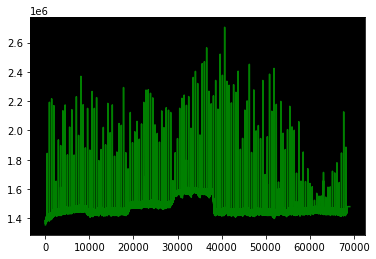

In [35]:
plt.plot(pulsar_data, color='green')

In [36]:
metadata_path = '../../LOFAR_2e_jaars_RP_2022_voor_studenten/Data_Pulsar1/L197621_SAP0_BEAM1_DM12.44_Mask.inf'
#metadata_path = '../../LOFAR_2e_jaars_RP_2022_voor_studenten/Data_Pulsar1/L197621_SAP0_BEAM1_DM12.44.inf'
with open(metadata_path) as f:
    metadata = f.readlines()

short_list(metadata)

' Data file name without suffix          =  L197621_SAP0_BEAM1_DM12.44_Mask\n,\t Telescope used                         =  LOFAR\n,\t...\t,\n,\t\n'

In [37]:
nbins = int(get_metadata_item(metadata, 'Number of bins in the time series'))
dt = float(get_metadata_item(metadata, 'Width of each time series bin (sec)'))

(0.0, 209.80255598842447)

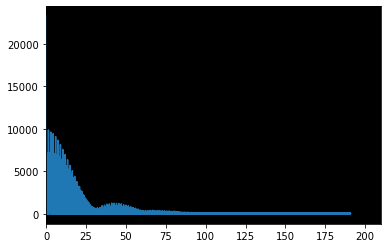

In [38]:
frequencies  = np.fft.fftfreq(nbins, dt)
transform = np.fft.fft(pulsar_data) / len(pulsar_data) # normalize the transform.
plt.clf()
plt.plot(frequencies[1:], abs(transform[1:]))
plt.xlim(0) # to remove the symmetry from the plot.

## Calculation using built-in fftfreq of numpy. 

In [39]:
from scipy.signal import find_peaks
height_threshold = 4700 # Just reading off an apprpriate value from the graph
peaks_index, properties = find_peaks(np.abs(transform), height=height_threshold)

In [10]:
peak_frequencies = [frequencies[i] for i in peaks_index]

(0.0, 25.0)

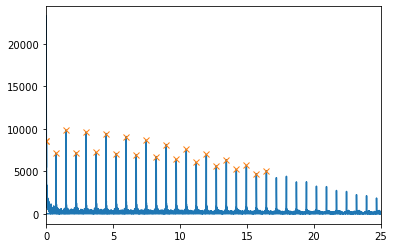

In [11]:
# Just change the height threshold above if we want less peaks to be marked.
plt.clf()
plt.plot(frequencies[1:], np.abs(transform[1:]),'-', frequencies[peaks_index],properties['peak_heights'],'x')
plt.xlim(0,25)

# automated period finding of pulsar

In [43]:
def find_period(peaks_index, frequencies):
    counter = -1
    list_frequencies_harmonics = []
    for index in peaks_index:
        counter += 1
        if counter ==0:
            freq = frequencies[index]
        else:
            freq = frequencies[index]/counter
        list_frequencies_harmonics.append(freq)
    index = 0
    list_frequencies_harmonics = np.array(list(filter(lambda x: x>0, list_frequencies_harmonics)))
    final_freq = np.mean(list_frequencies_harmonics[1:])
    length = len(list_frequencies_harmonics)
    period = final_freq ** -1
    return period, list_frequencies_harmonics, final_freq

## stacking

In [44]:
period, list_frequencies_harmonics, final_freq = find_period(peaks_index=peaks_index, frequencies=frequencies)

In [45]:
period_in_index = int(round(period // dt)) # TODO: Can we get this int thing away?? i cannot because it needs to be used as index for list
stack_dict = dict()
i = 0
while i <= nbins:
    stack_dict[f"stack{i // period_in_index}"] = np.array( pulsar_data[i:i+period_in_index])
    i += period_in_index

In [48]:
std = np.std(list_frequencies_harmonics[1:])

def err_period(freq, std_freq):
    error = (std_freq)/(freq**2)
    return error

error_period = err_period(final_freq, std)
print(error_period)
print(std)
print(final_freq)

0.0010500471847445113
0.0005867894857325556
0.7475439900153389


In [28]:
stack = np.zeros(period_in_index) # initializing with zeroes to get the correct stack size.
for key, val in stack_dict.items():
    if ( length := len(val) ) != period_in_index: # This should only happen happen at the end.
        continue
    else:
        stack += val
len(stack) == period_in_index

True

Text(0.5, 1.0, 'graph of an addition of signals of the first radio pulsar ever found.')

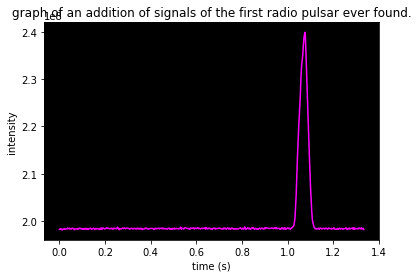

In [29]:
plt.plot([ dt * t for t in range(len(stack))], stack, color='magenta')
plt.xlabel('time (s)')
plt.ylabel('intensity')
plt.title('graph of an addition of signals of the first radio pulsar ever found.')

<Figure size 432x288 with 0 Axes>

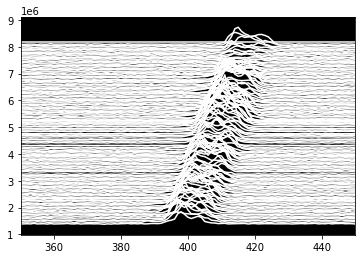

<Figure size 432x288 with 0 Axes>

In [30]:
plt.figure()
plt.rcParams['axes.facecolor']='black'
# NOTE: As a final version of this plot,
# if we want the pulses to be less overlapping we could simply skip indices of i.
for i, val in enumerate ( stack_dict.values() ) :
    offset = i * 0.05 * 10 **6
    plt.plot(stack_dict[f'stack{i}'] + offset, color='white') 
    plt.xlim(350,450)
plt.figure()